## Import Stuff


In [1]:
import warnings
import hopsworks
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")


## Connect to Hopsworks and Load Data


In [2]:
project = hopsworks.login(project="ATP_Tennis_Prediction")
fs = project.get_feature_store()
tennis_fg = fs.get_feature_group(
    name="tennis_matches",
    version=2,
)

2025-12-29 12:53:11,293 INFO: Initializing external client
2025-12-29 12:53:11,294 INFO: Base URL: https://eu-west.cloud.hopsworks.ai:443
2025-12-29 12:53:13,203 INFO: Python Engine initialized.

Logged in to project, explore it here https://eu-west.cloud.hopsworks.ai:443/p/3204


## EDA


In [3]:
tennis_df = tennis_fg.read()

print(f"Total records: {len(tennis_df):,}")
print(f"Total columns: {len(tennis_df.columns)}")
print("\nColumn names:")
print(tennis_df.columns.tolist())

print("\nTarget distribution:")
print(tennis_df["player_1_won"].value_counts())
print(tennis_df["player_1_won"].value_counts(normalize=True))

tennis_df.head()


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (36.18s) 
Total records: 400,074
Total columns: 53

Column names:
['date', 'player_1', 'player_2', 'best_of', 'rank_1', 'rank_2', 'rank_diff', 'pts_1', 'pts_2', 'pts_diff', 'odd_1', 'odd_2', 'odds_diff', 'p1_total_matches', 'p1_wins', 'p1_losses', 'p2_total_matches', 'p2_wins', 'p2_losses', 'player_1_won', 'p1_win_pct', 'p2_win_pct', 'p1_winpct_hard', 'p2_winpct_hard', 'p1_winpct_clay', 'p2_winpct_clay', 'p1_winpct_grass', 'p2_winpct_grass', 'p1_winpct_carpet', 'p2_winpct_carpet', 'p1_winpct_atp250', 'p2_winpct_atp250', 'p1_winpct_atp500', 'p2_winpct_atp500', 'p1_winpct_grand_slam', 'p2_winpct_grand_slam', 'p1_winpct_masters_1000', 'p2_winpct_masters_1000', 'p1_winpct_indoor', 'p2_winpct_indoor', 'p1_winpct_outdoor', 'p2_winpct_outdoor', 'tournament_encoded', 'surface_encoded', 'series_encoded', 'round_encoded', 'court_encoded', 'win_pct_diff', 'experience_diff', 'surface_advantage', 'series_advantage', 'court

,date,player_1,player_2,best_of,rank_1,rank_2,rank_diff,pts_1,pts_2,pts_diff,...,surface_encoded,series_encoded,round_encoded,court_encoded,win_pct_diff,experience_diff,surface_advantage,series_advantage,court_advantage,timestamp
0,2000-01-03,Agenor R.,Damm M.,3,94.0,104.0,-10.0,0,0,0,...,3,3,1,1,0.5,-1,0.5,0.0,0.5,2025-12-28
1,2000-01-03,Agenor R.,Kumar S.,3,94.0,1198.0,-1104.0,0,0,0,...,3,3,0,1,-0.0,0,-0.0,-0.0,-0.0,2025-12-28
2,2000-01-03,Agenor R.,Kumar S.,3,94.0,1198.0,-1104.0,0,0,0,...,3,3,0,1,-0.0,0,-0.0,-0.0,-0.0,2025-12-29
3,2000-01-03,Al-Alawi S.K.,Berasategui A.,3,54.0,60.0,-6.0,0,0,0,...,3,3,0,1,0.0,0,0.0,0.0,0.0,2025-12-28
4,2000-01-03,Arazi H.,Cherkasov A.,3,35.0,206.0,-171.0,0,0,0,...,3,3,0,1,0.0,0,0.0,0.0,0.0,2025-12-28


## Feature View


In [4]:
selected_features = tennis_fg.select_all()
selected_features.show(10)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (24.54s) 


,date,player_1,player_2,best_of,rank_1,rank_2,rank_diff,pts_1,pts_2,pts_diff,...,surface_encoded,series_encoded,round_encoded,court_encoded,win_pct_diff,experience_diff,surface_advantage,series_advantage,court_advantage,timestamp
0,2000-01-03,Agenor R.,Damm M.,3,94.0,104.0,-10.0,0,0,0,...,3,3,1,1,0.5,-1,0.5,0.0,0.5,2025-12-28
1,2000-01-03,Agenor R.,Kumar S.,3,94.0,1198.0,-1104.0,0,0,0,...,3,3,0,1,-0.0,0,-0.0,-0.0,-0.0,2025-12-28
2,2000-01-03,Agenor R.,Kumar S.,3,94.0,1198.0,-1104.0,0,0,0,...,3,3,0,1,-0.0,0,-0.0,-0.0,-0.0,2025-12-29
3,2000-01-03,Al-Alawi S.K.,Berasategui A.,3,54.0,60.0,-6.0,0,0,0,...,3,3,0,1,0.0,0,0.0,0.0,0.0,2025-12-28
4,2000-01-03,Arazi H.,Cherkasov A.,3,35.0,206.0,-171.0,0,0,0,...,3,3,0,1,0.0,0,0.0,0.0,0.0,2025-12-28
5,2000-01-03,Arazi H.,Cherkasov A.,3,35.0,206.0,-171.0,0,0,0,...,3,3,0,1,0.0,0,0.0,0.0,0.0,2025-12-29
6,2000-01-03,Baccanello P.,Escude N.,3,655.0,40.0,615.0,0,0,0,...,3,3,0,1,-0.0,0,-0.0,-0.0,-0.0,2025-12-28
7,2000-01-03,Baccanello P.,Escude N.,3,655.0,40.0,615.0,0,0,0,...,3,3,0,1,-0.0,0,-0.0,-0.0,-0.0,2025-12-29
8,2000-01-03,Balcells J.,Henman T.,3,218.0,11.0,207.0,0,0,0,...,3,3,0,1,0.0,-2,-0.5,0.0,-0.5,2025-12-28
9,2000-01-03,Bastl G.,Berasategui A.,3,85.0,60.0,25.0,0,0,0,...,3,3,1,1,0.0,0,0.0,0.0,0.0,2025-12-29


In [5]:
feature_view = fs.get_or_create_feature_view(
    name="tennis_match_prediction",
    description="Tennis match features for predicting Player 1 win/loss",
    version=1,
    labels=["player_1_won"],
    query=selected_features,
)

In [6]:
# Run this first to verify:
sample = tennis_fg.read()
target_cols = [col for col in sample.columns if "won" in col.lower()]
print(f"Columns with 'won': {target_cols}")


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (26.59s) 
Columns with 'won': ['player_1_won']


## Model Data Preprocesing


In [7]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(test_size=0.2)
print(f"Training samples: {len(X_train):,}")
print(f"Testing samples: {len(X_test):,}")

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (30.73s) 
2025-12-29 12:55:27,719 INFO: Computing insert statistics
2025-12-29 12:55:28,040 INFO: Computing insert statistics
Training samples: 320,059
Testing samples: 80,015


In [8]:
drop_list = [
    # Metadata columns
    "date",  # When match occurred (not predictive)
    "player_1",  # Player name (text)
    "player_2",  # Player name (text)
    "winner",  # This IS the target in different form!
    "timestamp",  # When data was inserted
    # Categorical columns (we have encoded versions)
    "tournament",  # Have Tournament_Encoded
    "surface",  # Have Surface_Encoded
    "series",  # Have Series_Encoded
    "round",  # Have Round_Encoded
    "court",  # Have Court_Encoded
    "tournament_clean",  # Intermediate processing column
]

# Filter for columns that actually exist
cols_to_drop = [col for col in drop_list if col in X_train.columns]

print(f"Dropping {len(cols_to_drop)} columns: {cols_to_drop}")

train_features = X_train.drop(cols_to_drop, axis=1)
test_features = X_test.drop(cols_to_drop, axis=1)

print(f"Features used: {len(train_features.columns)}")
print(f"Column names: {train_features.columns.tolist()}")

Dropping 4 columns: ['date', 'player_1', 'player_2', 'timestamp']
Features used: 48
Column names: ['best_of', 'rank_1', 'rank_2', 'rank_diff', 'pts_1', 'pts_2', 'pts_diff', 'odd_1', 'odd_2', 'odds_diff', 'p1_total_matches', 'p1_wins', 'p1_losses', 'p2_total_matches', 'p2_wins', 'p2_losses', 'p1_win_pct', 'p2_win_pct', 'p1_winpct_hard', 'p2_winpct_hard', 'p1_winpct_clay', 'p2_winpct_clay', 'p1_winpct_grass', 'p2_winpct_grass', 'p1_winpct_carpet', 'p2_winpct_carpet', 'p1_winpct_atp250', 'p2_winpct_atp250', 'p1_winpct_atp500', 'p2_winpct_atp500', 'p1_winpct_grand_slam', 'p2_winpct_grand_slam', 'p1_winpct_masters_1000', 'p2_winpct_masters_1000', 'p1_winpct_indoor', 'p2_winpct_indoor', 'p1_winpct_outdoor', 'p2_winpct_outdoor', 'tournament_encoded', 'surface_encoded', 'series_encoded', 'round_encoded', 'court_encoded', 'win_pct_diff', 'experience_diff', 'surface_advantage', 'series_advantage', 'court_advantage']


## Train Models


In [9]:
xgb_model = XGBClassifier(random_state=42, eval_metric="logloss")
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
lr_model = LogisticRegression(random_state=42, max_iter=1000)
dt_model = DecisionTreeClassifier(random_state=42)

models = {
    "XGBoost": xgb_model,
    "Random Forest": rf_model,
    "Logistic Regression": lr_model,
    "Decision Tree": dt_model,
}

model_scores = {
    "XGBoost": {},
    "Random Forest": {},
    "Logistic Regression": {},
    "Decision Tree": {},
}

In [10]:
for name, model in models.items():
    print(f"Training {name}...")

    model.fit(train_features, y_train.values.ravel())

    y_pred = model.predict(test_features)
    y_pred_proba = model.predict_proba(test_features)[:, 1]

    # CLASSIFICATION METRICS (not MSE/R²!)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")
    print()

    # Store results
    model_scores[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC-AUC": roc_auc,
    }


Training XGBoost...
  Accuracy:  0.7225
  Precision: 0.7234
  Recall:    0.7187
  F1 Score:  0.7210
  ROC-AUC:   0.8053

Training Random Forest...
  Accuracy:  0.9883
  Precision: 0.9881
  Recall:    0.9884
  F1 Score:  0.9882
  ROC-AUC:   0.9989

Training Logistic Regression...
  Accuracy:  0.6934
  Precision: 0.6943
  Recall:    0.6890
  F1 Score:  0.6916
  ROC-AUC:   0.7644

Training Decision Tree...
  Accuracy:  0.9856
  Precision: 0.9848
  Recall:    0.9865
  F1 Score:  0.9856
  ROC-AUC:   0.9856



## Feature Engineering


In [11]:
odds_cols = [col for col in train_features.columns if "odd" in col or "odds" in col]
if len(odds_cols) > 0:
    train_no_odds = train_features.drop(odds_cols, axis=1)
    test_no_odds = test_features.drop(odds_cols, axis=1)

    xgb_no_odds = XGBClassifier(random_state=42, eval_metric="logloss")
    xgb_no_odds.fit(train_no_odds, y_train.values.ravel())
    y_pred_no_odds = xgb_no_odds.predict(test_no_odds)

    accuracy_with = model_scores["XGBoost"]["Accuracy"]
    accuracy_without = accuracy_score(y_test, y_pred_no_odds)

    print(f"With odds:    {accuracy_with:.4f}")
    print(f"Without odds: {accuracy_without:.4f}")


With odds:    0.7225
Without odds: 0.7085


## Choose Best Model


In [12]:
final_model = XGBClassifier(random_state=42, eval_metric="logloss")
final_model.fit(train_features, y_train.values.ravel())

y_pred_final = final_model.predict(test_features)
y_pred_proba_final = final_model.predict_proba(test_features)[:, 1]

# Final metrics
final_accuracy = accuracy_score(y_test, y_pred_final)
final_precision = precision_score(y_test, y_pred_final)
final_recall = recall_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final)
final_roc_auc = roc_auc_score(y_test, y_pred_proba_final)

print("Final Performance:")
print(f"  Accuracy:  {final_accuracy:.4f}")
print(f"  Precision: {final_precision:.4f}")
print(f"  Recall:    {final_recall:.4f}")
print(f"  F1 Score:  {final_f1:.4f}")
print(f"  ROC-AUC:   {final_roc_auc:.4f}")


Final Performance:
  Accuracy:  0.7225
  Precision: 0.7234
  Recall:    0.7187
  F1 Score:  0.7210
  ROC-AUC:   0.8053


## Feature Analysis


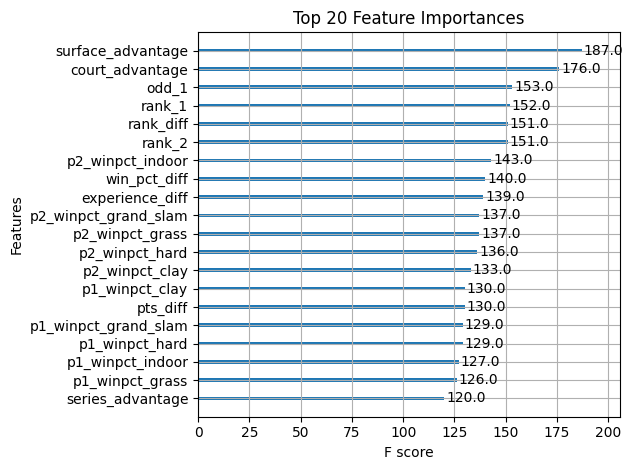

In [13]:
from xgboost import plot_importance
import pandas as pd

# Get feature importance as DataFrame
feature_importance = pd.DataFrame(
    {"Feature": train_features.columns, "Importance": final_model.feature_importances_}
).sort_values("Importance", ascending=False)

plot_importance(final_model, max_num_features=20)
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()

In [14]:
n_samples = 10

for i in range(n_samples):
    pred = y_pred_final[i]
    actual = y_test.iloc[i, 0]
    prob = y_pred_proba_final[i]

    pred_label = "P1 Wins" if pred == 1 else "P2 Wins"
    actual_label = "P1 Wins" if actual == 1 else "P2 Wins"
    correct = "C" if pred == actual else "W"

    print(
        f"{i + 1}. Predicted: {pred_label} ({prob:.2%}) | Actual: {actual_label} {correct}"
    )


1. Predicted: P2 Wins (47.28%) | Actual: P1 Wins W
2. Predicted: P2 Wins (28.54%) | Actual: P2 Wins C
3. Predicted: P2 Wins (35.79%) | Actual: P1 Wins W
4. Predicted: P2 Wins (18.71%) | Actual: P2 Wins C
5. Predicted: P2 Wins (49.69%) | Actual: P1 Wins W
6. Predicted: P1 Wins (74.05%) | Actual: P1 Wins C
7. Predicted: P1 Wins (51.24%) | Actual: P1 Wins C
8. Predicted: P2 Wins (21.20%) | Actual: P2 Wins C
9. Predicted: P1 Wins (70.19%) | Actual: P1 Wins C
10. Predicted: P1 Wins (83.76%) | Actual: P1 Wins C


In [15]:
from hsml.model_schema import ModelSchema
from hsml.schema import Schema

input_schema = Schema(train_features)
output_schema = Schema(y_test)

model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

print("Model schema created")


Model schema created


In [16]:
print("Retraining final model from scratch...")

# Create fresh XGBoost model
final_model = XGBClassifier(
    random_state=42,
    eval_metric="logloss",
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
)

# Train
final_model.fit(train_features, y_train.values.ravel())

# Verify it works
y_pred_final = final_model.predict(test_features)
y_pred_proba_final = final_model.predict_proba(test_features)[:, 1]

final_accuracy = accuracy_score(y_test, y_pred_final)
final_precision = precision_score(y_test, y_pred_final)
final_recall = recall_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final)
final_roc_auc = roc_auc_score(y_test, y_pred_proba_final)

print("Final Model Retrained:")
print(f"   Type: {type(final_model)}")
print(f"   Accuracy: {final_accuracy:.4f}")
print(f"   F1 Score: {final_f1:.4f}")
print(f"   ROC-AUC: {final_roc_auc:.4f}")

# Update metrics dictionary
metrics_dict = {
    "Accuracy": str(round(final_accuracy, 4)),
    "Precision": str(round(final_precision, 4)),
    "Recall": str(round(final_recall, 4)),
    "F1 Score": str(round(final_f1, 4)),
    "ROC-AUC": str(round(final_roc_auc, 4)),
}


Retraining final model from scratch...
Final Model Retrained:
   Type: <class 'xgboost.sklearn.XGBClassifier'>
   Accuracy: 0.7041
   F1 Score: 0.7032
   ROC-AUC: 0.7827


In [17]:
import os

mr = project.get_model_registry()

model_dir = "tennis_model"
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

# Use get_booster() method for XGBoost
final_model.get_booster().save_model(model_dir + "/model.json")
print(f"Model saved to {model_dir}/model.json")

# Register in Hopsworks
tennis_prediction_model = mr.python.create_model(
    name="tennis_match_predictor",
    metrics=metrics_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values,
    description="XGBoost Classifier for predicting tennis match outcomes (Player 1 Win/Loss)",
)

tennis_prediction_model.save(model_dir)

print("Model registered successfully!")
print("Name: tennis_match_predictor")
print(f"   Version: {tennis_prediction_model.version}")
print(f"   Accuracy: {metrics_dict['Accuracy']}")


Model saved to tennis_model/model.json


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/pranavrajan/Desktop/ATP-Prediction-Service/tennis_model/model.json: 0.000%|          | 0/6504…

Uploading /Users/pranavrajan/Desktop/ATP-Prediction-Service/input_example.json: 0.000%|          | 0/596 elaps…

Uploading /Users/pranavrajan/Desktop/ATP-Prediction-Service/model_schema.json: 0.000%|          | 0/3807 elaps…

Model created, explore it at https://eu-west.cloud.hopsworks.ai:443/p/3204/models/tennis_match_predictor/3
Model registered successfully!
Name: tennis_match_predictor
   Version: 3
   Accuracy: 0.7041
